In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import json

warnings.filterwarnings(action='ignore')

In [6]:
def max_drawdown(date_series, capital_series):
    """
    计算最大回撤
    :param date_series: 日期序列
    :param capital_series: 收益序列
    :return:输出最大回撤及开始日期和结束日期
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['max2here'] = pd.Series.expanding(df['capital']).max()
    df['dd2here'] = df['capital'] / df['max2here'] - 1 
    temp = df.sort_values(by='dd2here').iloc[0][['date', 'dd2here']]
    max_dd = temp['dd2here']
    end_date = temp['date']

    df = df[df['date'] <= end_date]
    start_date = df.sort_values(by='capital', ascending=False).iloc[0]['date']
    return max_dd, start_date, end_date


def annual_return(date_series, capital_series, num_work):
    """
    计算年化收益率
    :param date_series: 日期序列
    :param capital_series:资产序列
    :return: 输出在回测期间的年化收益率
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    annual = pow(df.loc[len(df.index) - 1, 'capital'] / df.loc[0, 'capital'], num_work / len(capital_series)) - 1
    return annual

In [7]:
df = pd.read_excel('enhanced.xlsx', index_col=0, dtype={'Weight_pos':list})
df.Weight_pos = df.Weight_pos.apply(json.loads)

df.loc[:, :'SPX500'] = df.loc[:, :'SPX500'].apply(lambda x: x.pct_change().fillna(0))

months = list(np.unique([m[:-3] for m in df.index.astype(str).tolist()]))
select_col = df.loc[:, :'UXZ0'].columns.to_list()

out_df = pd.DataFrame()
for m in months:
    sub_df = df[m]
    short_weight = np.array(sub_df['Weight_pos'].apply(lambda x: x[:3]).values.tolist())
    long_weight = np.array(sub_df['Weight_pos'].apply(lambda x: x[3:]).values.tolist())
    if m < '2020-01':
        if int(m[2:4]) < 9:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if
                                                            ('0' + str(int(m[2:4]) + 1)) in x][:7]
        if int(m[2:4]) < 19:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if str(int(m[2:4]) + 1) in x][:7]
        if int(m[2:4]) == 19:
            col = [x for x in select_col if m[2:4] in x] + select_col[-12:-5]
    else:
        col = select_col[-12:]

    sub = sub_df[col]
    m1 = int(m[-2:])
    sub_df['Enhanced'] = (sub.iloc[:, m1:m1+7] * np.array(sub_df['Weight_pos'].values.tolist())).sum(axis=1)
    sub_df['Short_Return'] = (sub.iloc[:, m1:m1+3] * short_weight).sum(axis=1)
    sub_df['Long_Return'] = (sub.iloc[:, m1+3:m1+7] * long_weight).sum(axis=1)
    out_df = out_df.append(sub_df)

out_df[['VIX', 'SPX500', 'Enhanced','Short_Return', 'Long_Return']] = out_df[['VIX', 'SPX500', 'Enhanced','Short_Return', 'Long_Return']].apply(lambda x: (x+1).cumprod())

In [8]:
print('Max Drawdown: ', max_drawdown(out_df.index.tolist(), out_df['Enhanced']))
print('Annual Return: ', annual_return(out_df.index.tolist(), out_df['Enhanced'], 250))

Max Drawdown:  (-0.395886936731234, Timestamp('2014-01-22 00:00:00'), Timestamp('2018-12-03 00:00:00'))
Annual Return:  0.12006107075378236


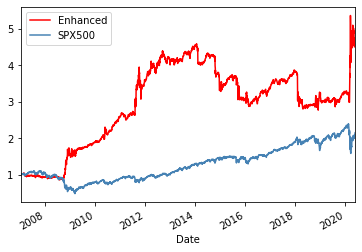

In [9]:
out_df[['Enhanced', 'SPX500']].plot(color=['r','steelblue'])

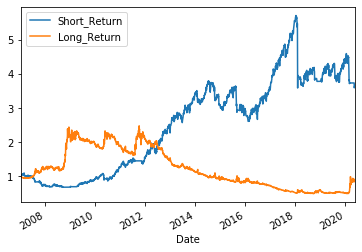

In [10]:
out_df[['Short_Return', 'Long_Return']].plot()